In [1]:
import imgaug as ia
import imgaug.augmenters as iaa
import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset
import cv2
import numpy as np
from sklearn.decomposition import PCA
from google.colab import drive
import math
from torchvision.utils import make_grid
import os, glob
import torch.nn as nn
from torch.nn import init
from torchvision.models import resnet18
from torch.utils.data import DataLoader
from PIL import Image
import time
import matplotlib.pyplot as plt


In [2]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
default_augmentations = iaa.Sequential([
            iaa.Fliplr(0.5),
            iaa.Flipud(0.5), 
            iaa.Rot90([0, 1, 2, 3])])

default_transforms = transforms.ToTensor()

KERNEL_SIZE = 21

In [4]:
class KernelImagePair(Dataset):
    def __init__(self, imgs:list, 
                 kernel_pickle:str,
                 scale:int,
                 augmentations:object,
                 transforms:object,
                 seed=0,
                 patch_size=(256,256),
                 train=True, noise=False, interpolation="cubic", downsample_on_pipe=True):
        super(KernelImagePair, self).__init__()
        self._kernel_dict = torch.load(kernel_pickle)
        
        self.kernels = self._kernel_dict['kernels']  # N x (21*21) 2d
        self.kernel_size = (KERNEL_SIZE, KERNEL_SIZE)  # (21, 21)
        self.k_reduced = self._kernel_dict['kernels_compressed']  # N x 21  2d
        self.stddevs = self._kernel_dict['sigmas']  # N standard deviations

        self.pca = self._kernel_dict['pca']  # PCA object (sklearn.decomposition)
        
        self.imgs = imgs
        self.scale = scale
        self.augmentations = augmentations
        
        self.transforms = transforms
        self.seed = seed
        self.patch_size = patch_size
        self.train=train
        self.downsample_on_pipe = downsample_on_pipe
        
        if interpolation == "cubic":
            self.inter = cv2.INTER_CUBIC

        self.random = np.random.RandomState(seed)
        self.noise = None
        if noise:
            self.noise = iaa.AdditiveGaussianNoise(scale=(0.03*255, 0.1*255))
            
    def __getitem__(self, idx) -> dict:
        img = self.imgs[idx]
        img = cv2.imread(img, cv2.IMREAD_COLOR)
        
        if self.train:
            """
            Random Crop image Adding margin w.r.t kernel_size and patch_size
            """
            img_from, img_to = np.zeros(2, dtype=int), np.zeros(2, dtype=int)
            for i in range(2):
                img_from[i] = self.random.randint(0, img.shape[i] - (self.kernel_size[i] + 1 + self.patch_size[i]))
                img_to[i] = img_from[i] + self.kernel_size[i] + 1 + self.patch_size[i]
            img_patch = img[img_from[0]:img_to[0], img_from[1]:img_to[1]]
        else:
            img_patch = img[138:201,224:287]
        
        if self.train and self.augmentations is not None:
            img_patch = self.augmentations.augment_image(img_patch)
            img = img_patch
        
        # Select kernel randomly
        kernel_idx = self.random.randint(len(self.kernels))
        stddev = self.stddevs[kernel_idx]

        gaussian_kernel = self.kernels[kernel_idx].reshape(KERNEL_SIZE, KERNEL_SIZE).astype(np.float32)

        if self.downsample_on_pipe:
            img_blur = cv2.filter2D(img_patch, ddepth=-1, kernel=gaussian_kernel)

        k_reduced = self.k_reduced[kernel_idx].astype(np.float32)

        if self.train:            
            half = self.kernel_size[0] // 2 + 1, self.kernel_size[1] // 2 + 1
            img_blur = img_blur[half[0] : -half[0], half[1]:-half[1]]
            img = img[half[0] : -half[0], half[1]:-half[1]]
            img_lr = cv2.resize(img_blur, 
                                (self.patch_size[0]//self.scale, self.patch_size[1]//self.scale), self.inter)
        else:
          img_lr = img_patch

        if self.noise is not None:
                img_lr = self.noise.augment_image(img_lr)
        if self.downsample_on_pipe:
            img_lr = cv2.resize(img_blur, 
                    (img.shape[1]//self.scale, img.shape[0]//self.scale), self.inter)

        if self.transforms is not None:
            if self.train:
                if not img_lr.flags['C_CONTIGUOUS']:
                    img_lr = np.ascontiguousarray(img_lr)
                if not img.flags['C_CONTIGUOUS']:
                    img = np.ascontiguousarray(img)

            img_lr = self.transforms(img_lr)
            img = self.transforms(img)
        

        re_dict = dict(LR=img_lr,
                    HR=img,
                    k=gaussian_kernel,
                    k_reduced=k_reduced,
                    stddev=stddev,
                    )      
        return re_dict

    def __len__(self):
        return len(self.imgs)

In [5]:
def tensor2img(tensor, out_type=np.uint8, min_max=(0, 1)):
    '''
    Converts a torch Tensor into an image Numpy array
    Input: 4D(B,(3/1),H,W), 3D(C,H,W), or 2D(H,W), any range, RGB channel order
    Output: 3D(H,W,C) or 2D(H,W), [0,255], np.uint8 (default)
    '''
    tensor = tensor.squeeze().float().cpu().clamp_(*min_max)  # clamp
    tensor = (tensor - min_max[0]) / (min_max[1] - min_max[0])  # to range [0,1]
    n_dim = tensor.dim()
    if n_dim == 4:
        n_img = len(tensor)
        img_np = make_grid(tensor, padding=0, nrow=1, normalize=False).numpy()
        img_np = np.transpose(img_np[[2, 1, 0], :, :], (1, 2, 0))  # HWC, BGR
    elif n_dim == 3:
        img_np = tensor.numpy()
        img_np = np.transpose(img_np[[2, 1, 0], :, :], (1, 2, 0))  # HWC, BGR
    elif n_dim == 2:
        img_np = tensor.numpy()
    else:
        raise TypeError(
            'Only support 4D, 3D and 2D tensor. But received with dimension: {:d}'.format(n_dim))
    if out_type == np.uint8:
        img_np = (img_np * 255.0).round()
        # Important. Unlike matlab, numpy.unit8() WILL NOT round by default.
    return img_np.astype(out_type)

In [6]:
class SFT_Layer(nn.Module):
    def __init__(self, nf=64, para=10):
        super(SFT_Layer, self).__init__()
        self.mul_conv1 = nn.Conv2d(para + nf, 32, kernel_size=3, stride=1, padding=1)
        self.mul_leaky = nn.LeakyReLU(0.2)
        self.mul_conv2 = nn.Conv2d(32, nf, kernel_size=3, stride=1, padding=1)

        self.add_conv1 = nn.Conv2d(para + nf, 32, kernel_size=3, stride=1, padding=1)
        self.add_leaky = nn.LeakyReLU(0.2)
        self.add_conv2 = nn.Conv2d(32, nf, kernel_size=3, stride=1, padding=1)

    def forward(self, feature_maps, para_maps):
        cat_input = torch.cat((feature_maps, para_maps), dim=1)
        mul = torch.sigmoid(self.mul_conv2(self.mul_leaky(self.mul_conv1(cat_input))))
        add = self.add_conv2(self.add_leaky(self.add_conv1(cat_input)))
        return feature_maps * mul + add


In [7]:
class SFT_Residual_Block(nn.Module):
    def __init__(self, nf=64, para=10):
        super(SFT_Residual_Block, self).__init__()
        self.sft1 = SFT_Layer(nf=nf, para=para)
        self.sft2 = SFT_Layer(nf=nf, para=para)
        self.conv1 = nn.Conv2d(in_channels=nf, out_channels=nf, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv2 = nn.Conv2d(in_channels=nf, out_channels=nf, kernel_size=3, stride=1, padding=1, bias=True)

    def forward(self, feature_maps, para_maps):
        fea1 = F.relu(self.sft1(feature_maps, para_maps))
        fea2 = F.relu(self.sft2(self.conv1(fea1), para_maps))
        fea3 = self.conv2(fea2)
        return torch.add(feature_maps, fea3)

In [8]:
class SFTMD(nn.Module):
    def __init__(self, in_nc=3, out_nc=3, nf=64, nb=16, scale=4, input_para=10, min=0.0, max=1.0):
        super(SFTMD, self).__init__()
        self.min = min
        self.max = max
        self.para = input_para
        self.num_blocks = nb

        self.conv1 = nn.Conv2d(in_nc, nf, 3, stride=1, padding=1)
        self.relu_conv1 = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv2d(nf, nf, 3, stride=1, padding=1)
        self.relu_conv2 = nn.LeakyReLU(0.2)
        self.conv3 = nn.Conv2d(nf, nf, 3, stride=1, padding=1)

        for i in range(nb):
            self.add_module('SFT-residual' + str(i + 1), SFT_Residual_Block(nf=nf, para=input_para))

        self.sft = SFT_Layer(nf=nf, para=input_para)
        self.conv_mid = nn.Conv2d(in_channels=nf, out_channels=nf, kernel_size=3, stride=1, padding=1, bias=True)

        if scale == 4: #x4
            self.upscale = nn.Sequential(
                nn.Conv2d(in_channels=nf, out_channels=nf * scale, kernel_size=3, stride=1, padding=1, bias=True),
                nn.PixelShuffle(scale // 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(in_channels=nf, out_channels=nf * scale, kernel_size=3, stride=1, padding=1, bias=True),
                nn.PixelShuffle(scale // 2),
                nn.LeakyReLU(0.2, inplace=True),
            )

        self.conv_output = nn.Conv2d(in_channels=nf, out_channels=out_nc, kernel_size=9, stride=1, padding=4, bias=True)

    def forward(self, input_dict):
        input = input_dict['LR']
        ker_code = input_dict['k_reduced']
        
        B, C, H, W = input.size() # I_LR batch
        B_h, C_h = ker_code.size() # Batch, Len=10
        ker_code_exp = ker_code.view((B_h, C_h, 1, 1)).expand((B_h, C_h, H, W)) #kernel_map stretch

        fea_bef = self.conv3(self.relu_conv2(self.conv2(self.relu_conv1(self.conv1(input)))))
        fea_in = fea_bef
        for i in range(self.num_blocks):
            fea_in = self.__getattr__('SFT-residual' + str(i + 1))(fea_in, ker_code_exp)
        fea_mid = fea_in
        fea_add = torch.add(fea_mid, fea_bef)
        fea = self.upscale(self.conv_mid(self.sft(fea_add, ker_code_exp)))
        out = self.conv_output(fea)
        
        return out

In [9]:
class Predictor(nn.Module):
    def __init__(self, pca, in_nc=3, nf=64, code_len=10, use_bias=True, kernel_size=21, original=False):
        super(Predictor, self).__init__()
        self.pca = pca
        self.register_buffer("mean_", torch.tensor(pca.mean_, dtype=torch.float32))
        self.register_buffer("components_", torch.tensor(pca.components_, dtype=torch.float32))
        self.code_len = code_len
        self.kernel_size = kernel_size
        self.original = original #original implementation : which returns reducted codes.

        self.ConvNet = nn.Sequential(*[
            nn.Conv2d(in_nc, nf, kernel_size=5, stride=1, padding=2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf, nf, kernel_size=5, stride=1, padding=2, bias=use_bias),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf, nf, kernel_size=5, stride=1, padding=2, bias=use_bias),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf, nf, kernel_size=5, stride=2, padding=2, bias=use_bias),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf, nf, kernel_size=5, stride=1, padding=2, bias=use_bias),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf, code_len, kernel_size=5, stride=1, padding=2, bias=use_bias),
            nn.LeakyReLU(0.2, True),
        ])

        self.globalPooling = nn.AdaptiveAvgPool2d((1,1))

    def forward(self, bd, recon_kernel=False):
        input = bd['LR']
        conv = self.ConvNet(input)
        flat = self.globalPooling(conv)
        flat = flat.view(flat.size()[:2]) # torch size: [B, code_len]
        if self.original or not recon_kernel:
            return flat

        if recon_kernel:
            recon = self.get_recon(flat)
            return recon
        else:
            return flat

In [10]:
class Corrector(nn.Module):
    def __init__(self, in_nc=3, nf=64, code_len=10, use_bias=True):
        super(Corrector, self).__init__()

        self.ConvNet = nn.Sequential(*[
            nn.Conv2d(in_nc, nf, kernel_size=5, stride=1, padding=2, bias=use_bias),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf, nf, kernel_size=5, stride=2, padding=2, bias=use_bias),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf, nf, kernel_size=5, stride=1, padding=2, bias=use_bias),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf, nf, kernel_size=5, stride=2, padding=2, bias=use_bias),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf, nf, kernel_size=5, stride=1, padding=2, bias=use_bias),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf, nf, kernel_size=5, stride=1, padding=2, bias=use_bias),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf, nf, kernel_size=5, stride=1, padding=2, bias=use_bias),
            nn.LeakyReLU(0.2, True),
        ])

        self.code_dense = nn.Sequential(*[
            nn.Linear(code_len, nf, bias=use_bias),
            nn.LeakyReLU(0.2, True),
            nn.Linear(nf, nf, bias=use_bias),
            nn.LeakyReLU(0.2, True),
        ])

        self.global_dense = nn.Sequential(*[
            nn.Conv2d(nf * 2, nf * 2, kernel_size=1, stride=1, padding=0, bias=use_bias),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf * 2, nf, kernel_size=1, stride=1, padding=0, bias=use_bias),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf, code_len, kernel_size=1, stride=1, padding=0, bias=use_bias),
        ])

        self.nf = nf
        self.globalPooling = nn.AdaptiveAvgPool2d([1, 1])
        self.res = False

    def forward(self, bd):
        input = bd['SR']
        code = bd['k_reduced']

        conv_input = self.ConvNet(input)
        B, C_f, H_f, W_f = conv_input.size() 

        conv_code = self.code_dense(code).view((B, self.nf, 1, 1)).expand((B, self.nf, H_f, W_f)) # h_stretch
        conv_mid = torch.cat((conv_input, conv_code), dim=1)
        code_res = self.global_dense(conv_mid)

        # Delta_h_p
        flat = self.globalPooling(code_res)
        Delta_h_p = flat.view(flat.size()[:2])

        if self.res:
            return Delta_h_p
        else:
            return Delta_h_p + code

In [11]:
class args():
    def __init__(self):
        self.scale = 4
        self.train_kernel = "/content/drive/My Drive/CS663_project/kernels_scale4dim10.pth"
        self.inter = "cubic"
        self.seed = None
        self.patch_size = 256
        self.augment = "default"
        self.use_noise = False
        self.batch_size=1
        self.num_step=1000
        self.validation_interval=500
        self.num_workers=4
        self.lr=0.00004
        self.lr_decay=0.4
        self.lr_min=1e-7
        self.lr_scheduler="cosine"
        self.optimizer="adam"
        self.loss="l2"
        self.metric="psnr"
        self.resume=False
        self.nf=64
        self.valid_rate=0.1
        self.kernel_dim=10
args = args()

In [12]:
def show_results(sr, ds):
    sr = tensor2img(sr)
    lr = Image.fromarray(tensor2img(ds['LR']))
    hr = Image.fromarray(tensor2img(ds['HR']))
#     display(lr)
#     display(lr.resize((lr.size[0]*scale, lr.size[1]*scale), Image.BICUBIC))
#     display(Image.fromarray(sr))
#     display(hr)
    fig = plt.figure(figsize=[6.4*6, 4.8*4])

    #fig.add_subplot(3,12,26)
    #plt.imshow(lr)
    fig.add_subplot(131)
    plt.imshow(lr.resize((lr.size[0]*scale, lr.size[1]*scale), Image.BICUBIC))
    fig.add_subplot(132)
    plt.imshow(sr)
    fig.add_subplot(133)
    plt.imshow(hr)

In [13]:
def metric(output, bd):
    with torch.no_grad():
        sr = output
        hr = bd['HR']
        diff = sr - hr
        shave = 4 + 10
        valid = diff[..., shave:-shave, shave:-shave]
        mse = valid.pow(2).mean()
        return -10 * torch.log10(mse)

In [14]:
real_imgs = glob.glob("/content/drive/My Drive/CS663_project/DIV2K_valid_LR_mild/*.png", recursive=True)
valid_imgs = glob.glob("/content/drive/My Drive/CS663_project/DIV2K_valid_HR/*.png", recursive=True)
valid_kernel = "/content/drive/My Drive/CS663_project/kernels_scale4dim10.pth"

scale=4
batch_size=1

In [15]:
valid_dataset = KernelImagePair(imgs=valid_imgs, kernel_pickle=valid_kernel, scale=scale, 
                                patch_size=(args.patch_size,args.patch_size) ,augmentations=default_augmentations, transforms=default_transforms, seed=0, train=True)
real_dataset = KernelImagePair(imgs=valid_imgs, kernel_pickle=valid_kernel, scale=scale, downsample_on_pipe=False,
                                patch_size=(args.patch_size,args.patch_size) ,augmentations=default_augmentations, transforms=default_transforms, seed=0, train=False)

In [16]:
dl = DataLoader(valid_dataset, batch_size=1, shuffle= False, num_workers=0, pin_memory=False)

In [36]:
rl = DataLoader(real_dataset, batch_size=1, shuffle= False, num_workers=0, pin_memory=False)

In [17]:

sftmd = SFTMD(input_para=args.kernel_dim, scale=args.scale, nf=args.nf).cuda()
predictor = Predictor(valid_dataset.pca, code_len=args.kernel_dim).cuda()
corrector = Corrector(nf=args.nf, code_len=args.kernel_dim).cuda()

path_sftmd = "/content/drive/My Drive/CS663_project/SFTMD_temp1000.pth"
path_predictor = "/content/drive/My Drive/CS663_project/Pred_final_250.pth"
path_corrector = "/content/drive/My Drive/CS663_project/corrector.pth"

sftmd.load_state_dict(torch.load(path_sftmd))
predictor.load_state_dict(torch.load(path_predictor))
corrector.load_state_dict(torch.load(path_corrector))

<All keys matched successfully>

In [ ]:
it = iter(dl)

In [ ]:
with torch.no_grad():
    ds = next(it)
    print(ds['stddev'])
    for k, v in ds.items():
        if torch.is_tensor(v):
            ds[k] = v.cuda()

tensor([3.6163], dtype=torch.float64)


**SFTMD Testing** 

torch.Size([1, 3, 256, 256])


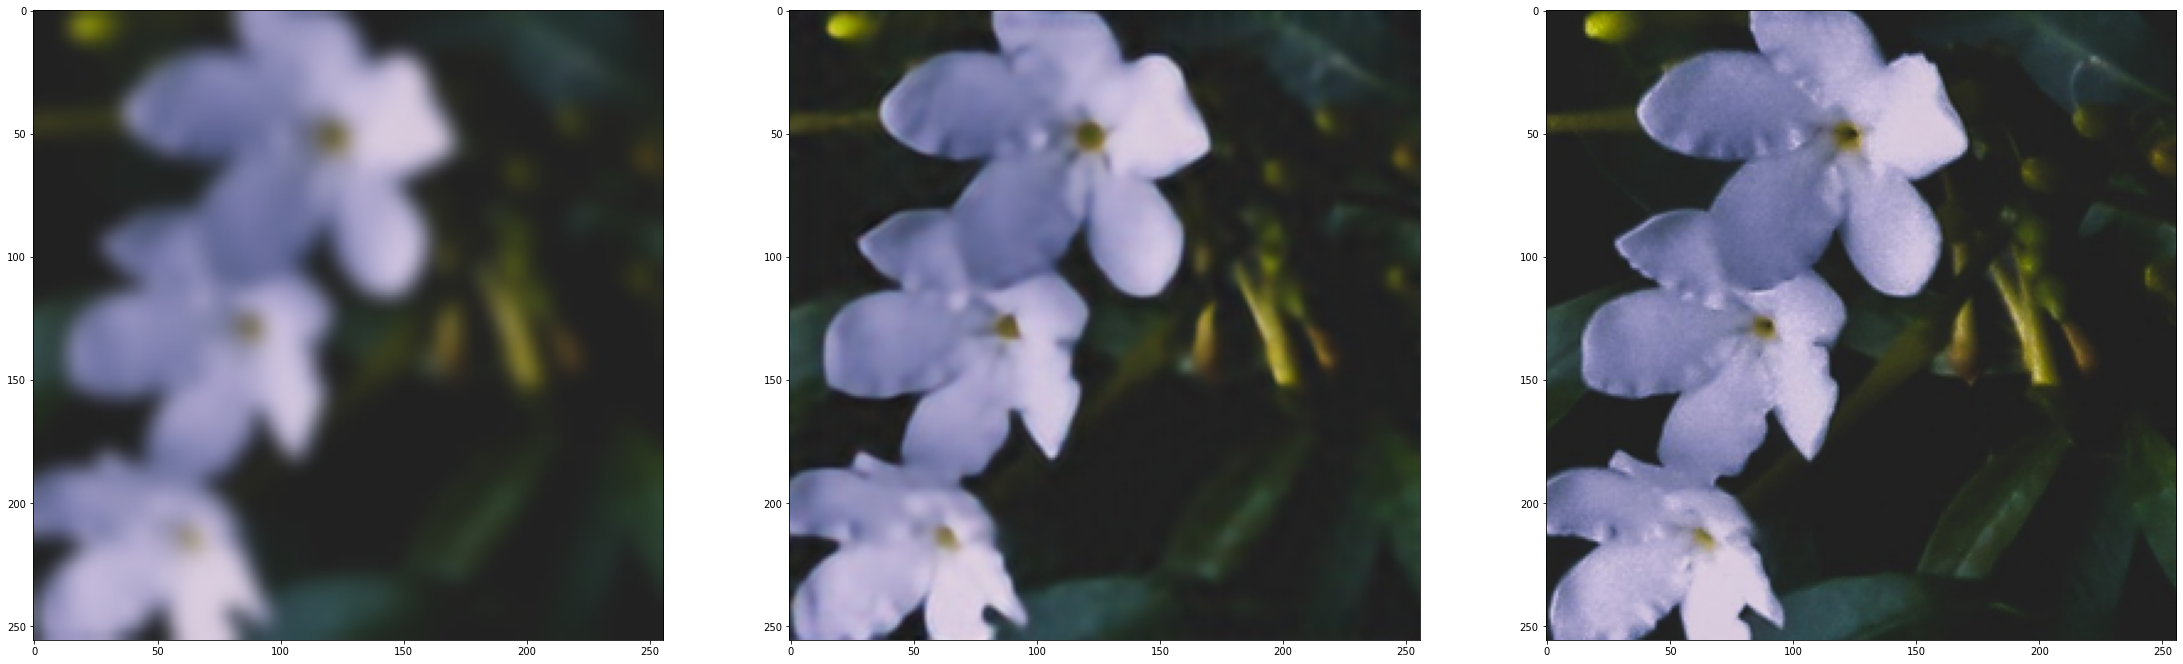

In [ ]:
with torch.no_grad():
    sr = sftmd(ds)
    print(sr.shape)
show_results(sr, ds)

**Predictor Testing**

0.007962799557094665 0.031017475 tensor([0.4937], device='cuda:0', dtype=torch.float64)


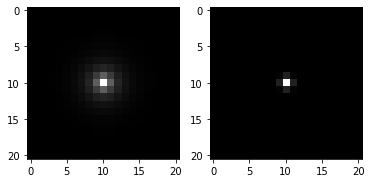

0.007355085828954742 0.003422407 tensor([3.2806], device='cuda:0', dtype=torch.float64)


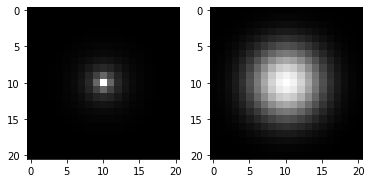

0.007655046195559187 0.023897806 tensor([0.5923], device='cuda:0', dtype=torch.float64)


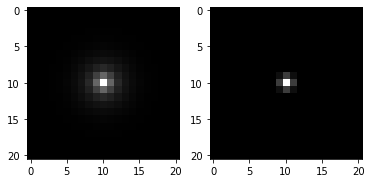

0.008559230349067158 0.010682699 tensor([1.2301], device='cuda:0', dtype=torch.float64)


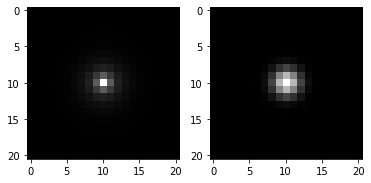

0.0076065220034413055 0.0034265004 tensor([3.2778], device='cuda:0', dtype=torch.float64)


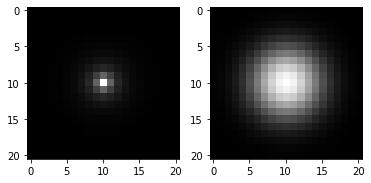

0.007347983363546315 0.01777547 tensor([0.7550], device='cuda:0', dtype=torch.float64)


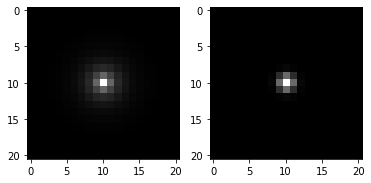

0.008069313294380823 0.008358162 tensor([1.5511], device='cuda:0', dtype=torch.float64)


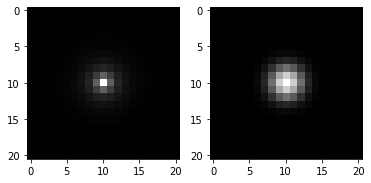

0.007377116919600814 0.004207652 tensor([2.8114], device='cuda:0', dtype=torch.float64)


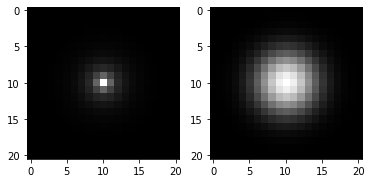

0.00727024143397456 0.003230178 tensor([3.4176], device='cuda:0', dtype=torch.float64)


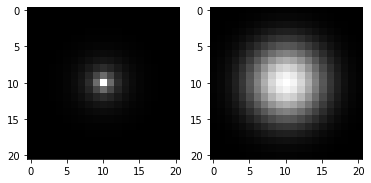

0.007156416919810134 0.004708599 tensor([2.5706], device='cuda:0', dtype=torch.float64)


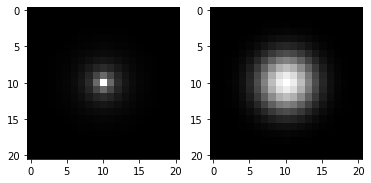

0.007748671698824165 0.0055384994 tensor([2.2446], device='cuda:0', dtype=torch.float64)


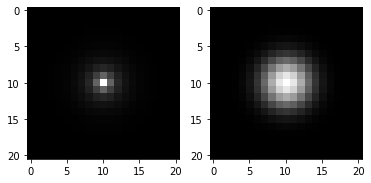

In [ ]:
for i, ds in enumerate(dl):
    if i > 10:
        break
    for k, v in ds.items():
        if torch.is_tensor(v):
            ds[k] = v.cuda()
    with torch.no_grad():
        k_estimated = predictor(ds)
    ds['k_save'] = ds['k']
    ds['k'] = k_estimated.cpu().numpy()
    k_np = ds['k_save'].cpu().numpy().reshape(21, 21)
    k_estimated_np = valid_dataset.pca.inverse_transform(ds['k']).reshape(21,21)
    
    print(np.std(k_estimated_np), np.std(k_np), ds['stddev'])
    
    plt.figure(figsize=(6,6))
    fig = plt.subplot(121)
    fig.imshow(k_estimated_np, cmap="gray")
    fig = plt.subplot(122)
    fig.imshow(k_np, cmap="gray")
    plt.show()

**Corrector Testing**

In [ ]:
with torch.no_grad():
    ds = next(it)
    print(ds['stddev'])
    for k, v in ds.items():
        if torch.is_tensor(v):
            ds[k] = v.cuda()

tensor([2.1282], dtype=torch.float64)


In [ ]:
kernels = []
srs = []
metrics = []

with torch.no_grad():
    k_reduced_gt = ds['k_reduced'][0]
    ds['k_reduced'] = predictor(ds)
    kernels.append(ds['k_reduced'][0])
    for i in range(7):
        sr = sftmd(ds)
        ds['SR'] = sr
        ds['k_reduced'] = corrector(ds)
        srs.append(sr[0])
        metrics.append(metric(sr, ds).item())
        kernels.append(ds['k_reduced'][0])

In [ ]:
pca = valid_dataset.pca
kr_recons = []
for kr in kernels:
    kr_np = kr.cpu().numpy()
    kr_recons.append(pca.inverse_transform(kr_np).reshape(21, 21))

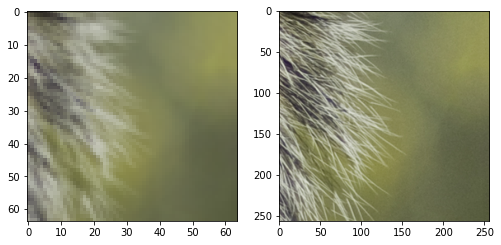

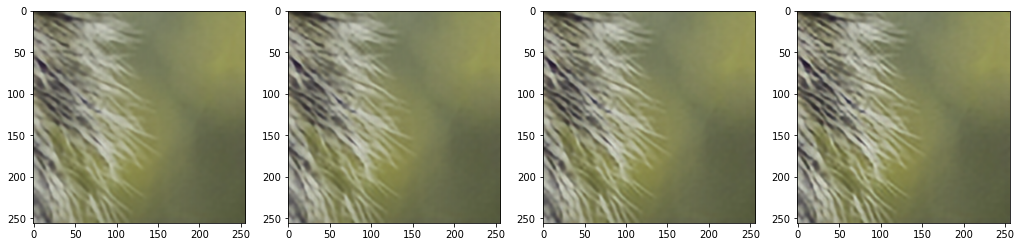

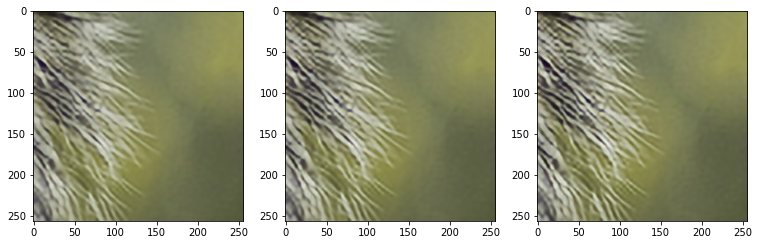

In [ ]:
  plt.figure(figsize=(12.8,9.6))
  fig = plt.subplot(131)
  fig.imshow(tensor2img(ds['LR'].cpu()))
  fig = plt.subplot(132)
  fig.imshow(tensor2img(ds['HR'].cpu()))

  plt.figure(figsize=(17.5,14.5))
  fig = plt.subplot(141)
  fig.imshow(tensor2img(srs[0].cpu()))
  fig = plt.subplot(142)
  fig.imshow(tensor2img(srs[1].cpu()))
  fig = plt.subplot(143)
  fig.imshow(tensor2img(srs[2].cpu()))
  fig = plt.subplot(144)
  fig.imshow(tensor2img(srs[3].cpu()))
  plt.show()

  plt.figure(figsize=(12.8,9.6))
  fig = plt.subplot(131)
  fig.imshow(tensor2img(srs[4].cpu()))
  fig = plt.subplot(132)
  fig.imshow(tensor2img(srs[5].cpu()))
  fig = plt.subplot(133)
  fig.imshow(tensor2img(srs[6].cpu()))
  plt.show()


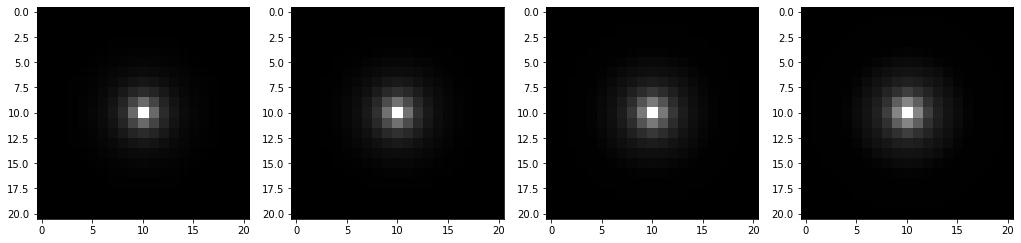

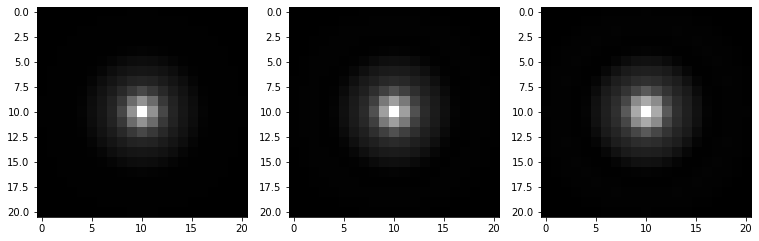

In [ ]:
  plt.figure(figsize=(17.5,14.5))
  fig = plt.subplot(141)
  fig.imshow(kr_recons[0], cmap="gray")
  fig = plt.subplot(142)
  fig.imshow(kr_recons[1], cmap="gray")
  fig = plt.subplot(143)
  fig.imshow(kr_recons[2], cmap="gray")
  fig = plt.subplot(144)
  fig.imshow(kr_recons[3], cmap="gray")
  plt.show()

  plt.figure(figsize=(12.8,9.6))
  fig = plt.subplot(131)
  fig.imshow(kr_recons[4], cmap="gray")
  fig = plt.subplot(132)
  fig.imshow(kr_recons[5], cmap="gray")
  fig = plt.subplot(133)
  fig.imshow(kr_recons[6], cmap="gray")
  plt.show()

In [37]:
it = iter(rl)

In [110]:
with torch.no_grad():
    ds = next(it)
    for k, v in ds.items():
        if torch.is_tensor(v):
            ds[k] = v.cuda()

In [111]:
kernels = []
srs = []
metrics = []

with torch.no_grad():
    k_reduced_gt = ds['k_reduced'][0]
    ds['k_reduced'] = predictor(ds)
    kernels.append(ds['k_reduced'][0])
    for i in range(7):
        sr = sftmd(ds)
        ds['SR'] = sr
        ds['k_reduced'] = corrector(ds)
        srs.append(sr[0])
        #metrics.append(metric(sr, ds).item())
        kernels.append(ds['k_reduced'][0])


In [112]:
pca = valid_dataset.pca
kr_recons = []
for kr in kernels:
    kr_np = kr.cpu().numpy()
    kr_recons.append(pca.inverse_transform(kr_np).reshape(21, 21))

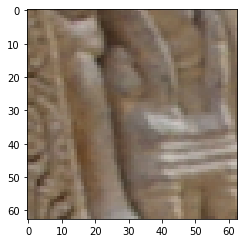

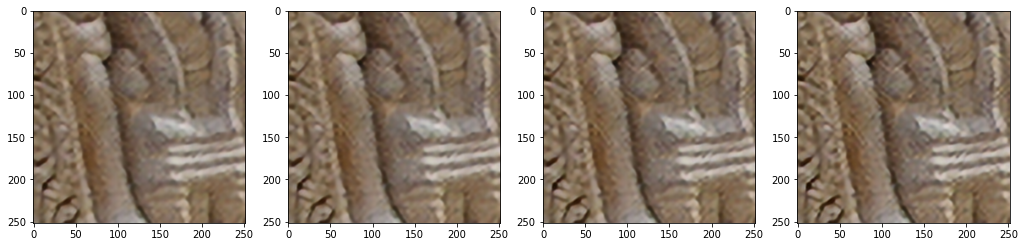

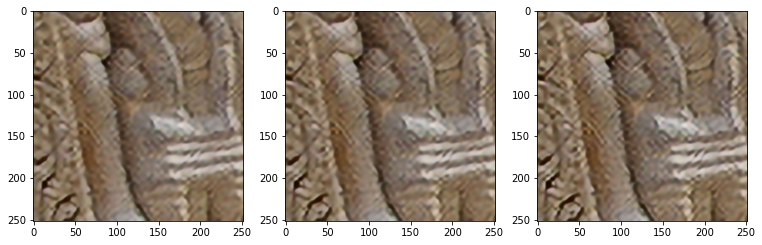

In [113]:
  plt.figure(figsize=(12.8,9.6))
  fig = plt.subplot(131)
  fig.imshow(tensor2img(ds['LR'].cpu()))

  plt.figure(figsize=(17.5,14.5))
  fig = plt.subplot(141)
  fig.imshow(tensor2img(srs[0].cpu()))
  fig = plt.subplot(142)
  fig.imshow(tensor2img(srs[1].cpu()))
  fig = plt.subplot(143)
  fig.imshow(tensor2img(srs[2].cpu()))
  fig = plt.subplot(144)
  fig.imshow(tensor2img(srs[3].cpu()))
  plt.show()

  plt.figure(figsize=(12.8,9.6))
  fig = plt.subplot(131)
  fig.imshow(tensor2img(srs[4].cpu()))
  fig = plt.subplot(132)
  fig.imshow(tensor2img(srs[5].cpu()))
  fig = plt.subplot(133)
  fig.imshow(tensor2img(srs[6].cpu()))
  plt.show()


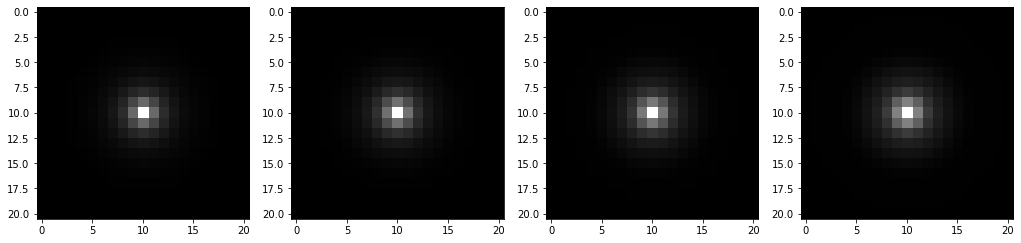

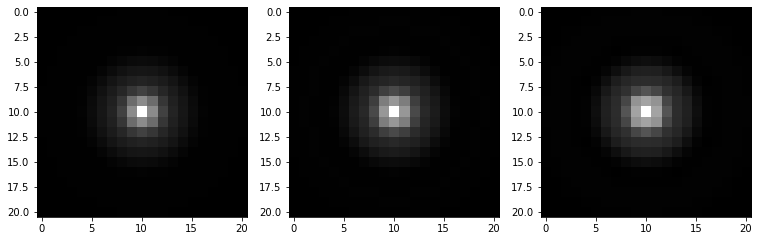

In [114]:
  plt.figure(figsize=(17.5,14.5))
  fig = plt.subplot(141)
  fig.imshow(kr_recons[0], cmap="gray")
  fig = plt.subplot(142)
  fig.imshow(kr_recons[1], cmap="gray")
  fig = plt.subplot(143)
  fig.imshow(kr_recons[2], cmap="gray")
  fig = plt.subplot(144)
  fig.imshow(kr_recons[3], cmap="gray")
  plt.show()

  plt.figure(figsize=(12.8,9.6))
  fig = plt.subplot(131)
  fig.imshow(kr_recons[4], cmap="gray")
  fig = plt.subplot(132)
  fig.imshow(kr_recons[5], cmap="gray")
  fig = plt.subplot(133)
  fig.imshow(kr_recons[6], cmap="gray")
  plt.show()

In [144]:
with torch.no_grad():
    ds = next(it)
    for k, v in ds.items():
        if torch.is_tensor(v):
            ds[k] = v.cuda()

In [145]:
kernels = []
srs = []
metrics = []

with torch.no_grad():
    k_reduced_gt = ds['k_reduced'][0]
    ds['k_reduced'] = predictor(ds)
    kernels.append(ds['k_reduced'][0])
    for i in range(7):
        sr = sftmd(ds)
        ds['SR'] = sr
        ds['k_reduced'] = corrector(ds)
        srs.append(sr[0])
        #metrics.append(metric(sr, ds).item())
        kernels.append(ds['k_reduced'][0])


In [146]:
pca = valid_dataset.pca
kr_recons = []
for kr in kernels:
    kr_np = kr.cpu().numpy()
    kr_recons.append(pca.inverse_transform(kr_np).reshape(21, 21))

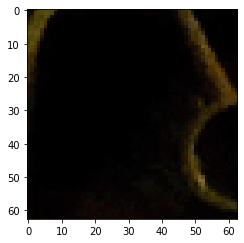

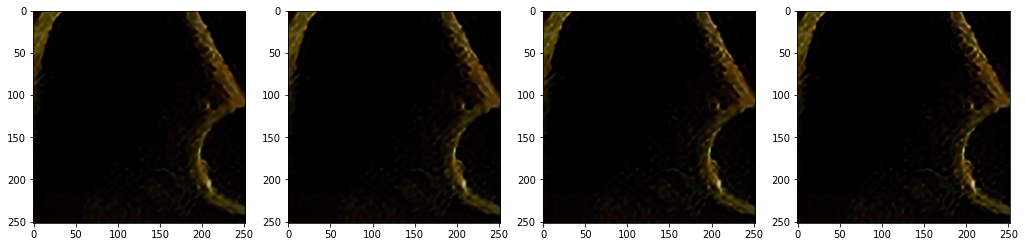

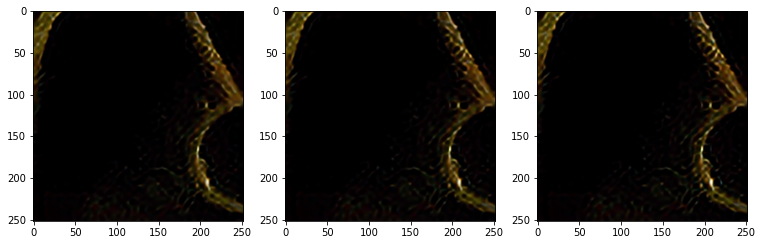

In [147]:
  plt.figure(figsize=(12.8,9.6))
  fig = plt.subplot(131)
  fig.imshow(tensor2img(ds['LR'].cpu()))

  plt.figure(figsize=(17.5,14.5))
  fig = plt.subplot(141)
  fig.imshow(tensor2img(srs[0].cpu()))
  fig = plt.subplot(142)
  fig.imshow(tensor2img(srs[1].cpu()))
  fig = plt.subplot(143)
  fig.imshow(tensor2img(srs[2].cpu()))
  fig = plt.subplot(144)
  fig.imshow(tensor2img(srs[3].cpu()))
  plt.show()

  plt.figure(figsize=(12.8,9.6))
  fig = plt.subplot(131)
  fig.imshow(tensor2img(srs[4].cpu()))
  fig = plt.subplot(132)
  fig.imshow(tensor2img(srs[5].cpu()))
  fig = plt.subplot(133)
  fig.imshow(tensor2img(srs[6].cpu()))
  plt.show()


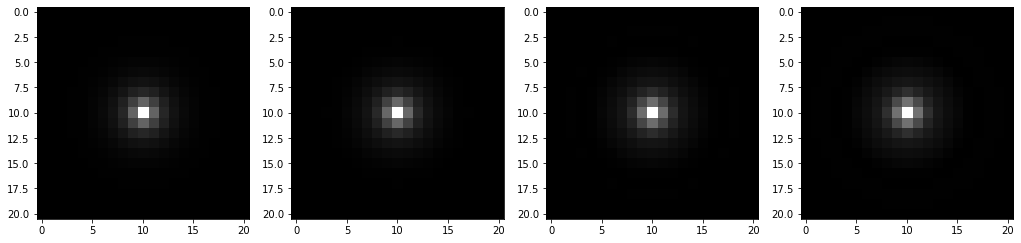

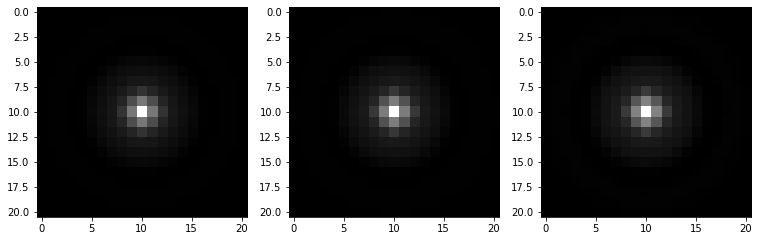

In [148]:
  plt.figure(figsize=(17.5,14.5))
  fig = plt.subplot(141)
  fig.imshow(kr_recons[0], cmap="gray")
  fig = plt.subplot(142)
  fig.imshow(kr_recons[1], cmap="gray")
  fig = plt.subplot(143)
  fig.imshow(kr_recons[2], cmap="gray")
  fig = plt.subplot(144)
  fig.imshow(kr_recons[3], cmap="gray")
  plt.show()

  plt.figure(figsize=(12.8,9.6))
  fig = plt.subplot(131)
  fig.imshow(kr_recons[4], cmap="gray")
  fig = plt.subplot(132)
  fig.imshow(kr_recons[5], cmap="gray")
  fig = plt.subplot(133)
  fig.imshow(kr_recons[6], cmap="gray")
  plt.show()